In [57]:
import os
import pandas as pd
import numpy as np
import yaml

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

### Read solution

In [58]:
solutions_path = Path("../moco/control_solutions/")
subject = "subject_1"
subject_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/Master_Robotics/Harvard/Thesis/subject_testing/subject_data/") / subject
trial = subject_data / "trial_2"

torque_profile_path = trial / "optimal_profile.csv"

torque_profile = pd.read_csv(torque_profile_path, index_col="Time")

In [59]:
def interpolate_dataframe(df, desired_frequency):
    time_vector = df.index
    time_vector_new = pd.Index(np.arange(time_vector.min(), time_vector.max(), 1/desired_frequency), name="Time")
    df_interpolated = df.reindex(time_vector_new, method="nearest").interpolate(method="polynomial", order=2)

    return df_interpolated

def smooth_dataframe(df, window_size):
    df_smoothed = df.rolling(window=window_size, min_periods=1, center=True).mean()
    return df_smoothed

### Smooth data

In [60]:
# Turn time into percentage
time_vector = (torque_profile.index - torque_profile.index.min())/(torque_profile.index.max() - torque_profile.index.min()) * 100

theta_1_dot = np.gradient(torque_profile.theta_1) / torque_profile.index.diff()
theta_2_dot = np.gradient(torque_profile.theta_2) / torque_profile.index.diff()

# Apply the smoothing function with a chosen window size
interpolated_profile = interpolate_dataframe(df=torque_profile, desired_frequency=200)
smoothed_torque_profile = smooth_dataframe(df=interpolated_profile, window_size=5)

### Scale profile to a set min/max value

In [61]:
# Define maximum absolute values for tau1 and tau2
max_tau1 = 5
max_tau2 = 2

# Scale the torque profiles
scale_factor_tau1 = max_tau1 / np.abs(smoothed_torque_profile['tau_1']).max()
scale_factor_tau2 = max_tau2 / np.abs(smoothed_torque_profile['tau_2']).max()
# Scaling torque profiles
print(f"Scaling factor tau1: {scale_factor_tau1:.3f}")
print(f"Scaling factor tau2: {scale_factor_tau2:.3f}")

scaled_torque_profile = smoothed_torque_profile.copy()
scaled_torque_profile['tau_1'] *= scale_factor_tau1
scaled_torque_profile['tau_2'] *= scale_factor_tau2

Scaling factor tau1: 0.034
Scaling factor tau2: 0.022


In [93]:
# Plot the scaled data
percentage_of_motion = (scaled_torque_profile.index - scaled_torque_profile.index.min())/(scaled_torque_profile.index.max() - scaled_torque_profile.index.min())* 100

scaled_torque_profile.index.name = "Percentage"
scaled_torque_profile.index = percentage_of_motion

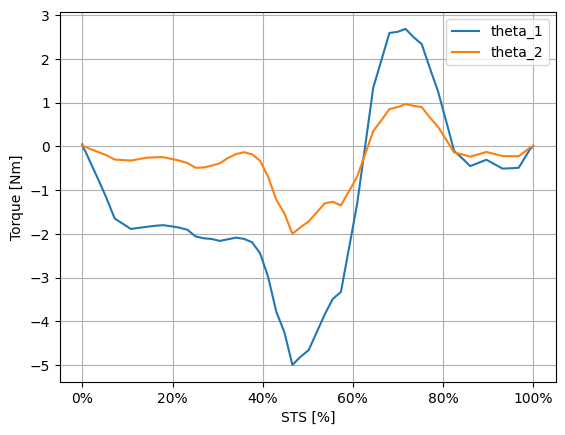

In [94]:
plt.grid()
plt.plot(percentage_of_motion, scaled_torque_profile.tau_1)
plt.plot(percentage_of_motion, scaled_torque_profile.tau_2)
plt.legend(scaled_torque_profile.columns)
plt.xlabel("STS [%]")
plt.ylabel("Torque [Nm]")

plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
plt.show()

### Transfer profile to raspberry pi

In [95]:
scaled_torque_path = trial / "scaled_torque_profile.csv"
scaled_torque_profile.to_csv(scaled_torque_path)

In [84]:
!scp {str(scaled_torque_path)} ABILITY_LAB_WLAN:/home/xabier/ability-lab/assistive-arm/torque_profiles/

scaled_torque_profile.csv                     100%   41KB   1.9MB/s   00:00    
